In [2]:
!pip install lightning
!pip install torchmetrics
!pip install matplotlib
!pip install pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 818.9/818.9 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
# -------------------------------
# 1. Import Required Libraries
# -------------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import lightning as L
import torchmetrics
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger
import matplotlib.pyplot as plt
import pandas as pd


In [5]:
# -------------------------------
# 2. Define the ResNet18 Model
# -------------------------------
class ResNet18Lightning(L.LightningModule):
    def __init__(self, num_classes=10):
        super().__init__()
        self.model = torchvision.models.resnet18(pretrained=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

        self.loss_fn = nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = self.accuracy(logits, y)
        self.log("val_loss", loss)
        self.log("val_accuracy", acc)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = self.accuracy(logits, y)
        self.log("test_loss", loss)
        self.log("test_accuracy", acc)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)


In [6]:
# -------------------------------
# 2. Define the ResNet18 Model
# -------------------------------
class ResNet18Lightning(L.LightningModule):
    def __init__(self, num_classes=10):
        super().__init__()
        self.model = torchvision.models.resnet18(pretrained=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

        self.loss_fn = nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = self.accuracy(logits, y)
        self.log("val_loss", loss)
        self.log("val_accuracy", acc)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = self.accuracy(logits, y)
        self.log("test_loss", loss)
        self.log("test_accuracy", acc)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)


In [7]:
# -------------------------------
# 3. Prepare Imagenette Dataset
# -------------------------------
from torchvision.datasets import Imagenette

train_transforms = transforms.Compose([
    transforms.CenterCrop(160),
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),  # Don't use Grayscale here
])

test_transforms = transforms.Compose([
    transforms.CenterCrop(160),
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

# Download training and test splits
train_dataset = Imagenette("data/imagenette/train/", split="train", size="160px", download=True, transform=train_transforms)

# Split training into train/val
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
val_dataset.dataset.transform = test_transforms

# Test split
test_dataset = Imagenette("data/imagenette/test/", split="val", size="160px", download=True, transform=test_transforms)

# Dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)


100%|██████████| 99.0M/99.0M [00:02<00:00, 38.4MB/s]
100%|██████████| 99.0M/99.0M [00:01<00:00, 76.6MB/s]


In [9]:
# -------------------------------
# 4. Training Setup (EarlyStopping + Logging)
# -------------------------------
model = ResNet18Lightning()

early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=3)
checkpoint = ModelCheckpoint(monitor="val_loss", mode="min", save_top_k=1)
logger = CSVLogger("logs", name="resnet18")

trainer = L.Trainer(
    max_epochs=20,
    callbacks=[early_stop, checkpoint],
    logger=logger,
    accelerator="auto"
)

trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | model    | ResNet             | 11.2 M | train
1 | loss_fn  | CrossEntropyLoss   | 0      | train
2 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
70        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name     | Type               | Params | Mode 
--------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [10]:
# -------------------------------
# 5. Evaluate on Test Set
# -------------------------------
trainer.test(model, dataloaders=test_loader)


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.6257324814796448     │
│         test_loss         │    1.5508522987365723     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.5508522987365723, 'test_accuracy': 0.6257324814796448}]

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the metrics file
metrics_path = "logs/resnet18/version_0/metrics.csv"  # Adjust version if needed
df = pd.read_csv(metrics_path)

# ✅ Check the actual columns available
print("Columns in metrics.csv:", df.columns)
print(df.head())


Columns in metrics.csv: Index(['epoch', 'step', 'train_loss', 'val_accuracy', 'val_loss'], dtype='object')
   epoch  step  train_loss  val_accuracy  val_loss
0      0    49    1.437274           NaN       NaN
1      0    66         NaN      0.517423  1.448085
2      1    99    1.181262           NaN       NaN
3      1   133         NaN      0.567054  1.373148
4      2   149    0.843879           NaN       NaN


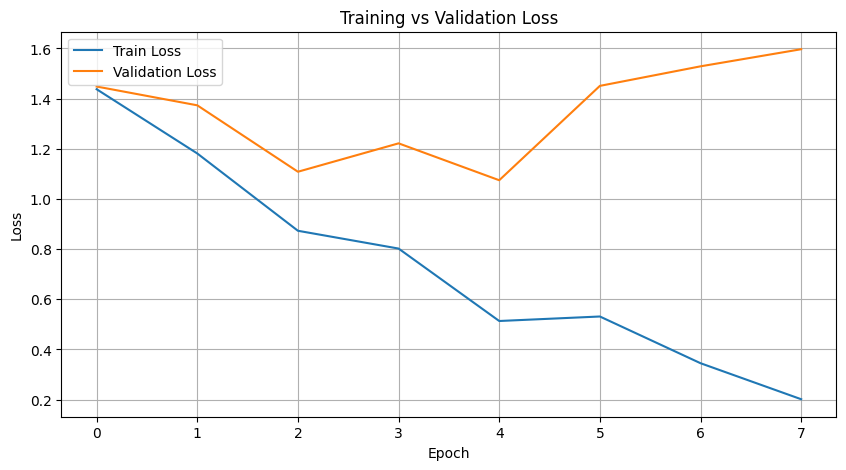

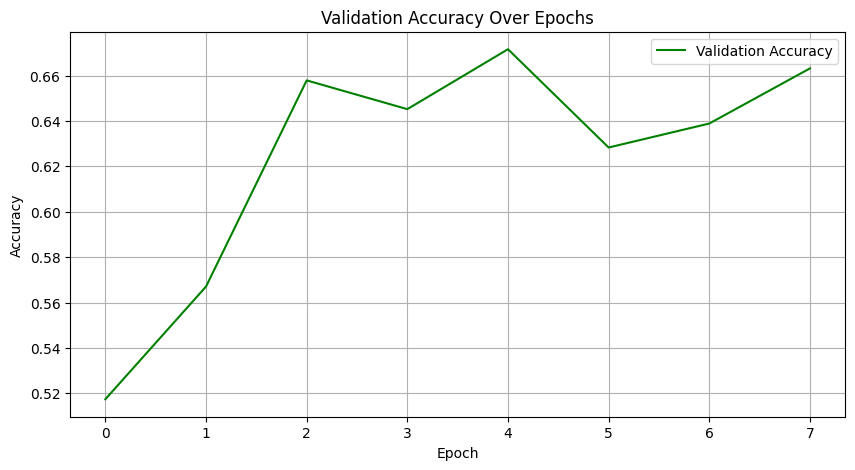

In [14]:
# Drop rows with missing validation entries
val_loss = df.dropna(subset=["val_loss"]).set_index("epoch")["val_loss"]
val_acc = df.dropna(subset=["val_accuracy"]).set_index("epoch")["val_accuracy"]

# Group training loss by epoch (averaging per epoch)
train_loss_avg = df.groupby("epoch")["train_loss"].mean()

# 📉 Plot: Training vs Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_avg.index, train_loss_avg.values, label="Train Loss")
plt.plot(val_loss.index, val_loss.values, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# ✅ Plot: Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_acc.index, val_acc.values, label="Validation Accuracy", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


In [20]:
from lightning.pytorch.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    monitor="val_loss",
    mode="min",
    save_top_k=1
)


In [21]:
import os

ckpt_dir = "logs/resnet18/version_0/checkpoints"
for file in os.listdir(ckpt_dir):
    print("Saved checkpoint:", os.path.join(ckpt_dir, file))


Saved checkpoint: logs/resnet18/version_0/checkpoints/epoch=4-step=335.ckpt


In [22]:
from google.colab import files

files.download(f"{ckpt_dir}/{file}")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
model = ResNet18Lightning.load_from_checkpoint("/content/epoch=4-step=335.ckpt")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
